In [ ]:
!pip install pandarallel
!pip install gensim --upgrade
!pip install pyLDAvis --upgrade
!pip install pyarrow
!pip install vaderSentiment

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 3.1 MB/s eta 0:00:00
  Created wheel for pandarallel: filename=pandarallel-1.6.5-py3-none-any.whl size=16674 sha256=b029982619d941d6909f7206c6d00980a2c800c152ea7b80635cbee8261829bb
  Stored in directory: /root/.cache/pip/wheels/b9/c6/5a/829298789e94348b81af52ab42c19d49da007306bbcc983827
Successfully built pandarallel
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 22.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import nltk
import nltk.corpus
from nltk.text import Text
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.util import ngrams
from nltk.metrics import jaccard_distance
from nltk.text import Text
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import os
import requests
import pprint
from joblib import dump, load
from pandarallel import pandarallel
import multiprocessing
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud


import os
import warnings
warnings.simplefilter('ignore')

import gensim
from gensim import corpora, models
from gensim.models.ldamulticore import LdaMulticore
from gensim.models import CoherenceModel

# import pyLDAvis.gensim
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 500)

nltk.download('all')

Mounted at /content/drive


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [ ]:
pandarallel.initialize(nb_workers = multiprocessing.cpu_count()-1, use_memory_fs=False, progress_bar = True)

INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [ ]:
df = pd.read_parquet('/content/drive/MyDrive/df_cleaned_tokenized.parquet', engine = 'pyarrow')
df

,url,date,language,title,text,year,month,day,dayofweek,title_cleaned,text_cleaned,title_cleaned_tokens,text_cleaned_tokens
0,http://www.dataweek.co.za/21690r,2024-04-05,en,Flash for AI - 28 March 2024 - EBV Electrolink - Dataweek,"\nFlash for AI - 28 March 2024 - EBV Electrolink - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nSubscribe\nAdvertise\n\n \n\nEMP Handbook\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ AI & ML\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Edge Computing & IIoT\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interconnection\n▸ Manufacturi...",2024,4,5,4,Flash for AI 28 March 2024 EBV Electrolink Dataweek,Flash for AI 28 March 2024 EBV Electrolink Dataweek Home About us Back issues Ebook PDF Subscribe Advertise EMP Handbook Categories Editors Choice Multimedia Videos AI ML Analogue Mixed Signal LSI Circuit System Protection ComputerEmbedded Technology Design Automation DSP Micros Memory Edge Computing IIoT Electronics Technology Enclosures Racks Cabinets Panel Products Events Interconnection Manufacturing Production Technology Hardware Services News OptoElec...,"[flash, ai, march, ebv, electrolink, dataweek]","[flash, ai, march, ebv, electrolink, dataweek, home, u, back, issue, ebook, pdf, subscribe, advertise, emp, handbook, category, editor, choice, multimedia, video, ai, ml, analogue, mixed, signal, lsi, circuit, system, protection, computerembedded, technology, design, automation, dsp, micros, memory, edge, computing, iiot, electronics, technology, enclosure, rack, cabinet, panel, product, event, interconnection, manufacturing, production, technology, hardware, service, news, optoelectronics, ..."
1,http://www.mysmartrend.com/news-briefs/technical-analysis/cr-bard-inc-has-returned-489-smartrend-recommendation-bcr-2,2020-04-17,en,Cr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) | Comtex SmarTrend,"\n\nCr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) | Comtex SmarTrend\n \nOWL LOGIN / \n ADVISOR LOGIN\n\nHome\nAdvantages\nProducts\n\nNews &amp Analysis\n\n\nResources\nTestimonials\n\n *Supporting investors at home - 60% off SmarTrend Products - Coupon Code: COVID19 \nReturn to Headlines\nCr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) \nWritten on Fri, 04/17/2020 - 1:08am\n By Shiri Gupta\nSmarTrend identified an Uptrend for Cr Ba...",2020,4,17,4,Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Comtex SmarTrend,Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Comtex SmarTrend OWL LOGIN ADVISOR LOGIN Home Advantages amp Analysis Resources Testimonials Supporting investors at home 60 off SmarTrend Products Coupon Code COVID19 Return to Headlines Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Written on Fri 04172020 108am By Shiri Gupta SmarTrend identified an Uptrend for Cr Bard Inc BCR on December 23rd 2016 at 22245 In approximate...,"[cr, bard, inc, returned, since, smartrend, recommendation, bcr, comtex, smartrend]","[cr, bard, inc, returned, since, smartrend, recommendation, bcr, comtex, smartrend, owl, login, advisor, login, home, advantage, amp, analysis, resource, testimonial, supporting, investor, home, smartrend, product, coupon, code, covid19, return, headline, cr, bard, inc, returned, since, smartrend, recommendation, bcr, written, fri, 108am, shiri, gupta, smartrend, identified, uptrend, cr, bard, inc, bcr, december, 23rd, approximately, month, cr, bard, inc, returned, today, recent, price, 3312..."
2,https://abcnews.go.com/Entertainment/video/ai-hiring-firing-focus-book-journalist-hilke-schellmann-108912618,2024-04-06,en,Video AI used for hiring and firing focus of book by journalist Hilke Schellmann - ABC News,\n\nVideo AI used for hiring and firing focus of book by journalist Hilke Schellmann - ABC News\n\nABC NewsVideoLiveShowsEl

In [ ]:
def get_gcs_data (bucket_name, folder_name, file_name, path_local):
    url = 'https://storage.googleapis.com/' + bucket_name + '/' + folder_name + '/' + file_name
    r = requests.get(url)
    open(path_local + '/' + file_name , 'wb').write(r.content)

In [ ]:
path_yelp_data = '/home/jupyter/yelp'
path_yelp_model = '/home/jupyter/data/yelp/yelp_model/'

os.makedirs(path_yelp_data, exist_ok=True)
os.makedirs(path_yelp_model, exist_ok=True)

In [ ]:
bucket_name = 'msca-bdp-data-open'
folder_name = 'yelp/yelp_model'
file_name = ['model.joblib',
             'nb.joblib', 'logreg.joblib', 'svm.joblib',
             'nb_small.joblib', 'logreg_small.joblib', 'svm_small.joblib']
path_local = path_yelp_model

os.makedirs(path_local, exist_ok=True)

for file in file_name:
    get_gcs_data (bucket_name = bucket_name,
                 folder_name = folder_name,
                 file_name = file,
                 path_local = path_local)
    print('Downloaded: ' + file)

Downloaded: model.joblib
Downloaded: nb.joblib
Downloaded: logreg.joblib
Downloaded: svm.joblib
Downloaded: nb_small.joblib
Downloaded: logreg_small.joblib
Downloaded: svm_small.joblib


In [ ]:
!ls -l /home/jupyter/data/yelp/yelp_model/

total 1874908
-rw-r--r-- 1 root root 522995808 Mar  6 14:40 logreg.joblib
-rw-r--r-- 1 root root   7420344 Mar  6 14:40 logreg_small.joblib
-rw-r--r-- 1 root root   7661465 Mar  6 14:40 model.joblib
-rw-r--r-- 1 root root 839186606 Mar  6 14:40 nb.joblib
-rw-r--r-- 1 root root  12203294 Mar  6 14:40 nb_small.joblib
-rw-r--r-- 1 root root 522996092 Mar  6 14:40 svm.joblib
-rw-r--r-- 1 root root   7420628 Mar  6 14:40 svm_small.joblib


In [ ]:
# Logistic Regression
%time clf_large = load(os.path.join(path_yelp_model, 'logreg.joblib'))

CPU times: user 30.5 s, sys: 2.72 s, total: 33.2 s
Wall time: 32.6 s


In [ ]:
%%time

y_pred = clf_large.predict(df['text_cleaned'])

CPU times: user 4min 29s, sys: 1.36 s, total: 4min 30s
Wall time: 4min 30s


In [ ]:
df['initial_sentiment'] = y_pred

In [ ]:
df[['text_cleaned', 'initial_sentiment']].head(10)

,text_cleaned,initial_sentiment
0,Flash for AI 28 March 2024 EBV Electrolink Dataweek Home About us Back issues Ebook PDF Subscribe Advertise EMP Handbook Categories Editors Choice Multimedia Videos AI ML Analogue Mixed Signal LSI Circuit System Protection ComputerEmbedded Technology Design Automation DSP Micros Memory Edge Computing IIoT Electronics Technology Enclosures Racks Cabinets Panel Products Events Interconnection Manufacturing Production Technology Hardware Services News OptoElec...,0
1,Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Comtex SmarTrend OWL LOGIN ADVISOR LOGIN Home Advantages amp Analysis Resources Testimonials Supporting investors at home 60 off SmarTrend Products Coupon Code COVID19 Return to Headlines Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Written on Fri 04172020 108am By Shiri Gupta SmarTrend identified an Uptrend for Cr Bard Inc BCR on December 23rd 2016 at 22245 In approximate...,1
2,Video AI used for hiring and firing focus of book by journalist Hilke Schellmann ABC NewsVideoLiveShowsElections538ShopInterest Successfully AddedWell notify you here with news aboutTurn on desktop notifications for breaking stories about interest OffOnLOG INStream onLatestNortheast earthquakeBiden in BaltimoreHow to photograph solar eclipseJobs report analysisAntiDEI legislationRochester solar eclipseAI used for hiring and firing focus of book by journalist Hilke Victor Oquendo spoke ...,0
3,Cory Doctorow experiments with AI writing partner Sudowrite Boing Boing Mark Frauenfelder 800 am Fri Aug 14 2020 Cory Doctorow experiments with AI writing partner Sudowrite Follow Us Twitter Facebook RSS Image Depositphotos GPT3 is a machinelearning trained language model that generates text based on a text prompt Cory Doctorow has been playing around with a closedbeta implementation of Sudowrite which he describes as a GPT3based text generator for fiction writers...,0
4,Artificial Intelligence Top AI CEOs experts raise risk of extinction from AI ET CIO X We use cookies to ensure best experience for you We use cookies and other tracking technologies to improve your browsing experience on our site show personalize content and targeted ads analyze site traffic and understand where our audience is coming from You can also read our privacy policy We use cookies to ensure the best experience for you on our website By choosing I accept or by continuing be...,0
5,Ua lawa anei ka 60000 e noho ai ma Vancouver E lele i ka maʻiʻoSat Kekemapa 2 2023 Ola KulanakauhaleKe wehe nei i nā ʻenehana hou a me ka mana o AI AINewsSpaceTechnologyukaliScienceUSHoʻokaʻaʻike AI Nā Kumuhana Hoʻonaʻauao Entertainment Aloha Ua lawa anei ka 60000 e noho ai ma Vancouver ByGabriel Botha Nov 29 2023 Title The Realities of Living in Vancouver on a 60000 IncomeIntroduction Living in Vancouver one of Canadas most vibrant and picturesque ci...,1
9,MicroCloud Hologram Develops Holographic Virtual Digital Human Using ChatGPT Technology Skip to contentSat Sep 9th 2023 CityLifeUnveiling New Technologies and the Power of AI AINewsSpaceTechnologySatelliteScienceUSContact Technology MicroCloud Hologram Develops Holographic Virtual Digital Human Using ChatGPT Technology ByRobert Andrew Sep 8 2023 MicroCloud Hologram Inc NASDAQ HOLO a leading provider of Hologram Digital Twins Technology has announced the dev...,1
11,Machine Learning Revolutionizes Surface Prediction for Multicomponent Materials Skip to contentFri Dec 8th 2023 CityLifeUnveiling New Technologies and the Power of AI AINewsSpaceTechnologySatelliteScienceUSContact Science Machine Learning Revolutionizes Surface Prediction for Multicomponent Materials ByVicky Stavropoulou Dec 7 2023 Machine learning algorithms have revolutionized the field of material science providing faster and more accurate prediction...,1
12,Nvidia stuns markets and signals how artificial intelligence could reshape technology sector CW33 Dallas Ft Worth Skip to content CW33 Dallas Ft Worth Dallas Ft Wo

In [ ]:
# 0 is negative, 1 is positive
df['initial_sentiment'].value_counts()

,count
initial_sentiment,
0,98844
1,60925


In [ ]:
#Create a handle to the SentimentIntensityAnalyzer object
analyzer = SentimentIntensityAnalyzer()

#function that outputs the sentiment ratings
def print_sentiment_ratings(sentence):
    sent = analyzer.polarity_scores(sentence)
    print("{} {}".format(sentence, sent))

In [ ]:
%%time
# Use parallel processing to calculate sentiment scores for each text in the 'clean_text' column.
df["sentiment_score"] = df["text_cleaned"].parallel_apply(lambda x: analyzer.polarity_scores(x)["compound"])


CPU times: user 21.1 s, sys: 4.72 s, total: 25.8 s
Wall time: 18min 38s


In [ ]:
def categorize_sentiment(score):
    if score >= 0.8:
        return "extremely positive"
    elif score >= 0.2:
        return "positive"
    elif score >= -0.2:
        return "neutral"
    elif score >= -0.8:
        return "negative"
    else:
        return "extremely negative"

df['sentiment'] = df['sentiment_score'].parallel_apply(categorize_sentiment)


In [ ]:
df.head()

,url,date,language,title,text,year,month,day,dayofweek,title_cleaned,text_cleaned,title_cleaned_tokens,text_cleaned_tokens,initial_sentiment,sentiment_score,sentiment
0,http://www.dataweek.co.za/21690r,2024-04-05,en,Flash for AI - 28 March 2024 - EBV Electrolink - Dataweek,"\nFlash for AI - 28 March 2024 - EBV Electrolink - Dataweek\nHome\nAbout us\nBack issues / E-book / PDF\nSubscribe\nAdvertise\n\n \n\nEMP Handbook\n\nCategories\n\n▸ Editor's Choice\n▸ Multimedia, Videos\n▸ AI & ML\n▸ Analogue, Mixed Signal, LSI\n▸ Circuit & System Protection\n▸ Computer/Embedded Technology\n▸ Design Automation\n▸ DSP, Micros & Memory\n▸ Edge Computing & IIoT\n▸ Electronics Technology\n▸ Enclosures, Racks, Cabinets & Panel Products\n▸ Events\n▸ Interconnection\n▸ Manufacturi...",2024,4,5,4,Flash for AI 28 March 2024 EBV Electrolink Dataweek,Flash for AI 28 March 2024 EBV Electrolink Dataweek Home About us Back issues Ebook PDF Subscribe Advertise EMP Handbook Categories Editors Choice Multimedia Videos AI ML Analogue Mixed Signal LSI Circuit System Protection ComputerEmbedded Technology Design Automation DSP Micros Memory Edge Computing IIoT Electronics Technology Enclosures Racks Cabinets Panel Products Events Interconnection Manufacturing Production Technology Hardware Services News OptoElec...,"[flash, ai, march, ebv, electrolink, dataweek]","[flash, ai, march, ebv, electrolink, dataweek, home, u, back, issue, ebook, pdf, subscribe, advertise, emp, handbook, category, editor, choice, multimedia, video, ai, ml, analogue, mixed, signal, lsi, circuit, system, protection, computerembedded, technology, design, automation, dsp, micros, memory, edge, computing, iiot, electronics, technology, enclosure, rack, cabinet, panel, product, event, interconnection, manufacturing, production, technology, hardware, service, news, optoelectronics, ...",0,0.9995,extremely positive
1,http://www.mysmartrend.com/news-briefs/technical-analysis/cr-bard-inc-has-returned-489-smartrend-recommendation-bcr-2,2020-04-17,en,Cr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) | Comtex SmarTrend,"\n\nCr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) | Comtex SmarTrend\n \nOWL LOGIN / \n ADVISOR LOGIN\n\nHome\nAdvantages\nProducts\n\nNews &amp Analysis\n\n\nResources\nTestimonials\n\n *Supporting investors at home - 60% off SmarTrend Products - Coupon Code: COVID19 \nReturn to Headlines\nCr Bard Inc Has Returned 48.9% Since SmarTrend Recommendation (BCR) \nWritten on Fri, 04/17/2020 - 1:08am\n By Shiri Gupta\nSmarTrend identified an Uptrend for Cr Ba...",2020,4,17,4,Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Comtex SmarTrend,Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Comtex SmarTrend OWL LOGIN ADVISOR LOGIN Home Advantages amp Analysis Resources Testimonials Supporting investors at home 60 off SmarTrend Products Coupon Code COVID19 Return to Headlines Cr Bard Inc Has Returned 489 Since SmarTrend Recommendation BCR Written on Fri 04172020 108am By Shiri Gupta SmarTrend identified an Uptrend for Cr Bard Inc BCR on December 23rd 2016 at 22245 In approximate...,"[cr, bard, inc, returned, since, smartrend, recommendation, bcr, comtex, smartrend]","[cr, bard, inc, returned, since, smartrend, recommendation, bcr, comtex, smartrend, owl, login, advisor, login, home, advantage, amp, analysis, resource, testimonial, supporting, investor, home, smartrend, product, coupon, code, covid19, return, headline, cr, bard, inc, returned, since, smartrend, recommendation, bcr, written, fri, 108am, shiri, gupta, smartrend, identified, uptrend, cr, bard, inc, bcr, december, 23rd, approximately, month, cr, bard, inc, returned, today, recent, price, 3312...",1,0.9821,extremely positive
2,https://abcnews.go.com/Entertainment/video/ai-hiring-firing-focus-book-journalist-hilke-schellmann-108912618,2024-04-06,en,Video AI used for hiring and firing focus of book by journalist Hilke Schellmann - ABC News,\n\nVideo AI used for h

In [ ]:
# Vader provides lesser no. of negative sentiment
df["sentiment"].value_counts()

,count
sentiment,
extremely positive,145470
extremely negative,7805
positive,3318
negative,2188
neutral,988


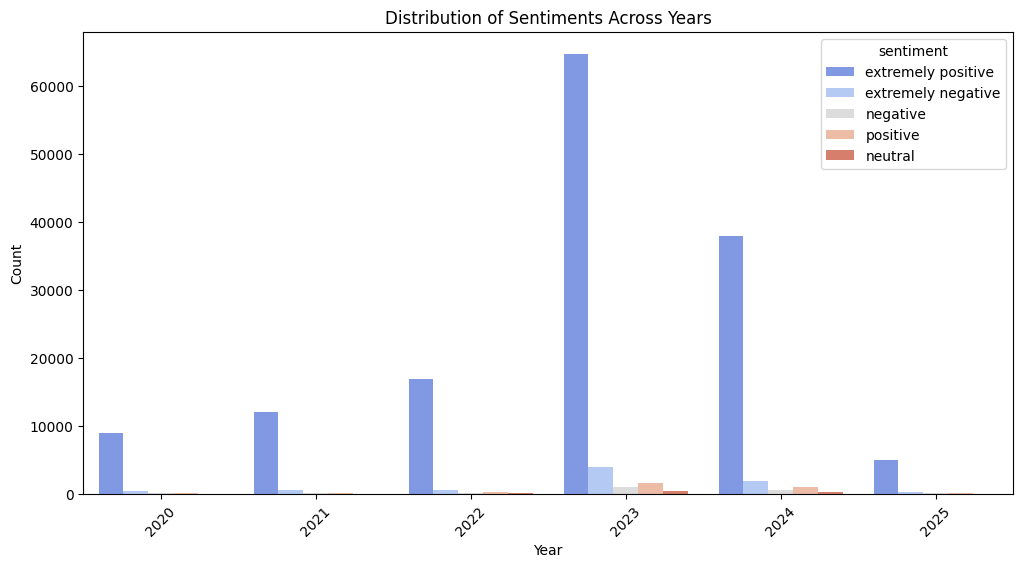

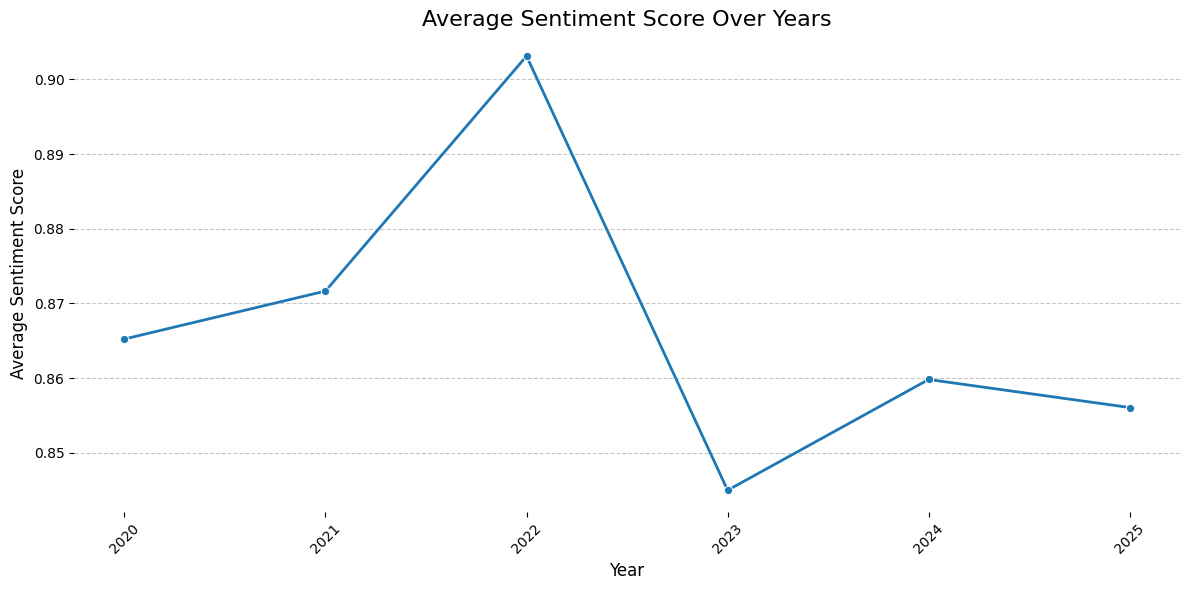

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(x='year', hue='sentiment', data=df,palette='coolwarm')
plt.title('Distribution of Sentiments Across Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Calculate the average sentiment score for each year
average_sentiment_by_year = df.groupby('year')['sentiment_score'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sentiment_score', data=average_sentiment_by_year, marker='o', linestyle='-', linewidth=2, palette='coolwarm')
plt.title('Average Sentiment Score Over Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

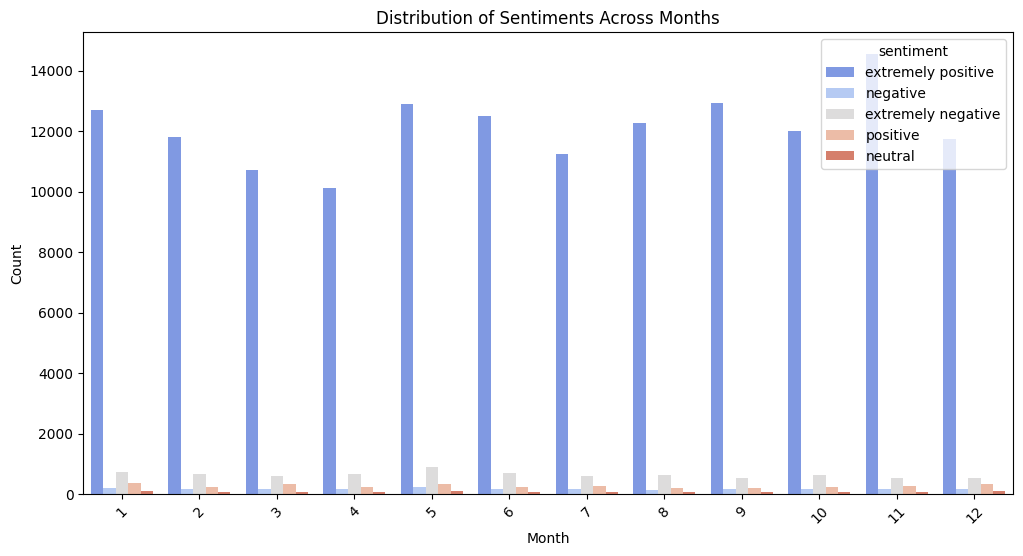

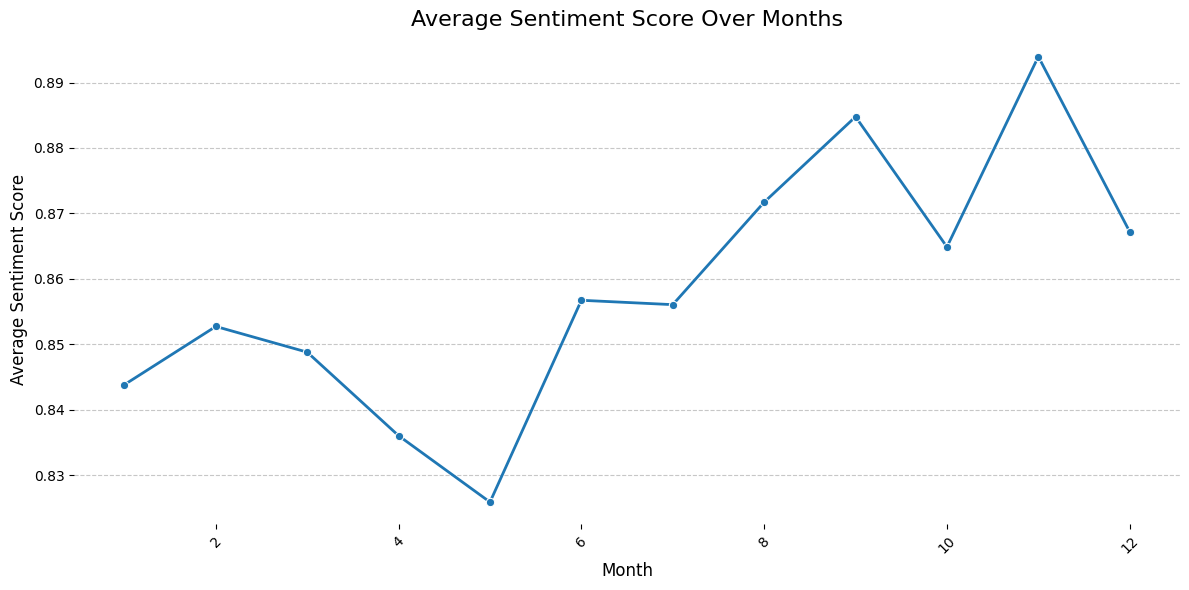

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(x='month', hue='sentiment', data=df,palette='coolwarm')
plt.title('Distribution of Sentiments Across Months')
plt.xlabel('Month')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Calculate the average sentiment score for each month
average_sentiment_by_month = df.groupby('month')['sentiment_score'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='sentiment_score', data=average_sentiment_by_month, marker='o', linestyle='-', linewidth=2, palette='coolwarm')
plt.title('Average Sentiment Score Over Months', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


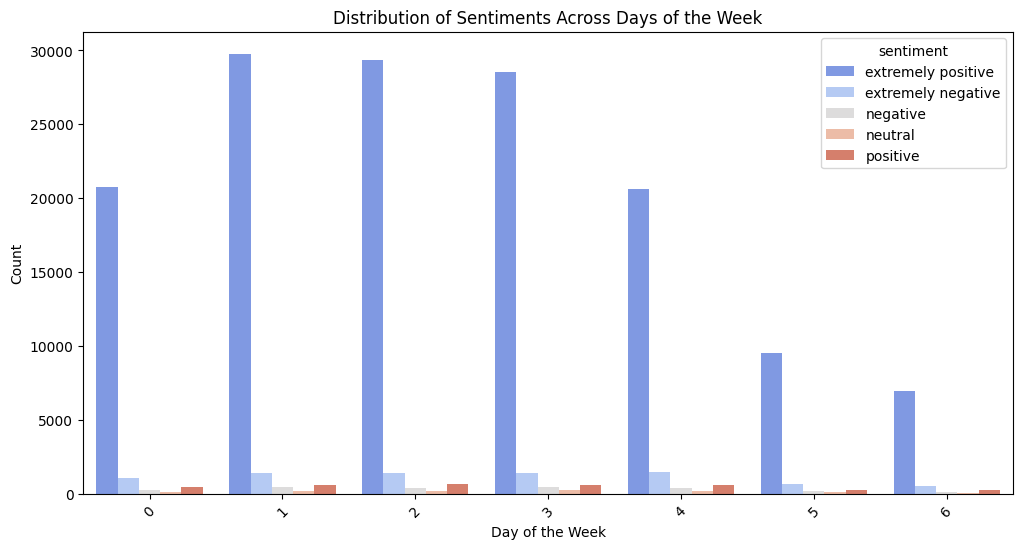

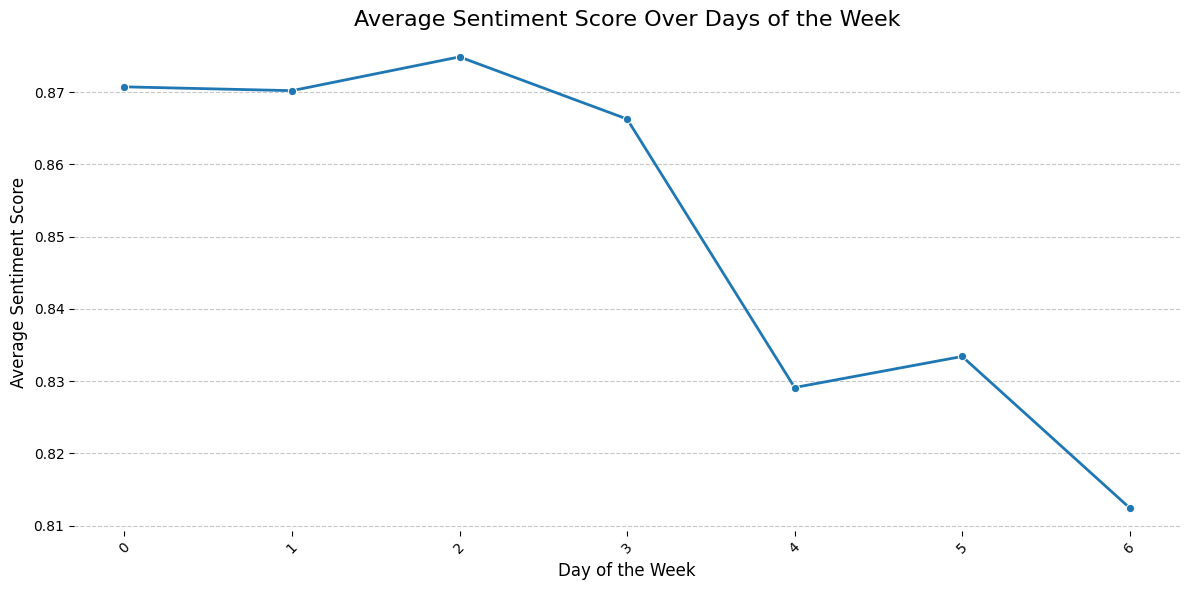

In [ ]:
# Create the plot
plt.figure(figsize=(12, 6))
sns.countplot(x='dayofweek', hue='sentiment', data=df, palette='coolwarm')
plt.title('Distribution of Sentiments Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


# Calculate the average sentiment score for each day of the week
average_sentiment_by_day = df.groupby('dayofweek')['sentiment_score'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='dayofweek', y='sentiment_score', data=average_sentiment_by_day, marker='o', linestyle='-', linewidth=2, palette='coolwarm')
plt.title('Average Sentiment Score Over Days of the Week', fontsize=16)
plt.xlabel('Day of the Week', fontsize=12)
plt.ylabel('Average Sentiment Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


In [ ]:
pos_text = ' '.join(df['text_cleaned'][df["sentiment"].isin(["extremely positive", "positive"])].values)
neg_text = ' '.join(df['text_cleaned'][df["sentiment"].isin(["extremely negative", "negative"])].values)

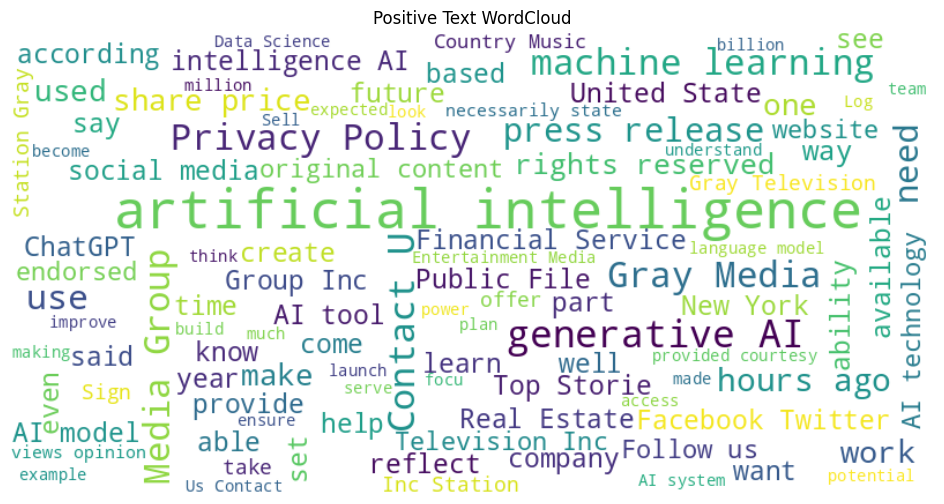

In [ ]:
# Create a WordCloud object
positive_wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(pos_text)

# Display the generated image:
plt.figure(figsize=(12, 6))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Positive Text WordCloud')
plt.show()


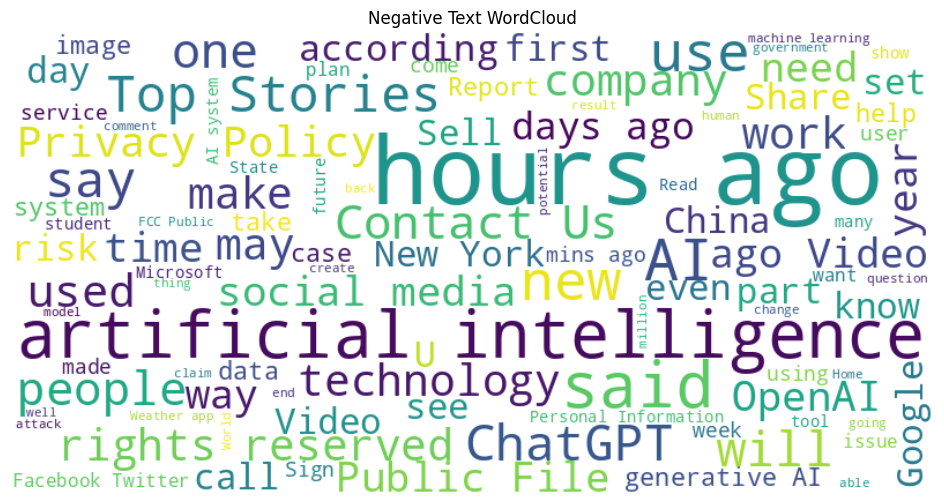

CPU times: user 28.4 s, sys: 1.53 s, total: 29.9 s
Wall time: 29.6 s


In [ ]:
%%time

# Create a WordCloud object
negative_wordcloud = WordCloud(width=800, height=400, background_color="white", max_words=100).generate(neg_text)

# Display the generated image:
plt.figure(figsize=(12, 6))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title('Negative Text WordCloud')
plt.show()

In [ ]:
pos_df = df[df["sentiment"].isin(["extremely positive", "positive"])]
neg_df = df[df["sentiment"].isin(["extremely negative", "negative"])]

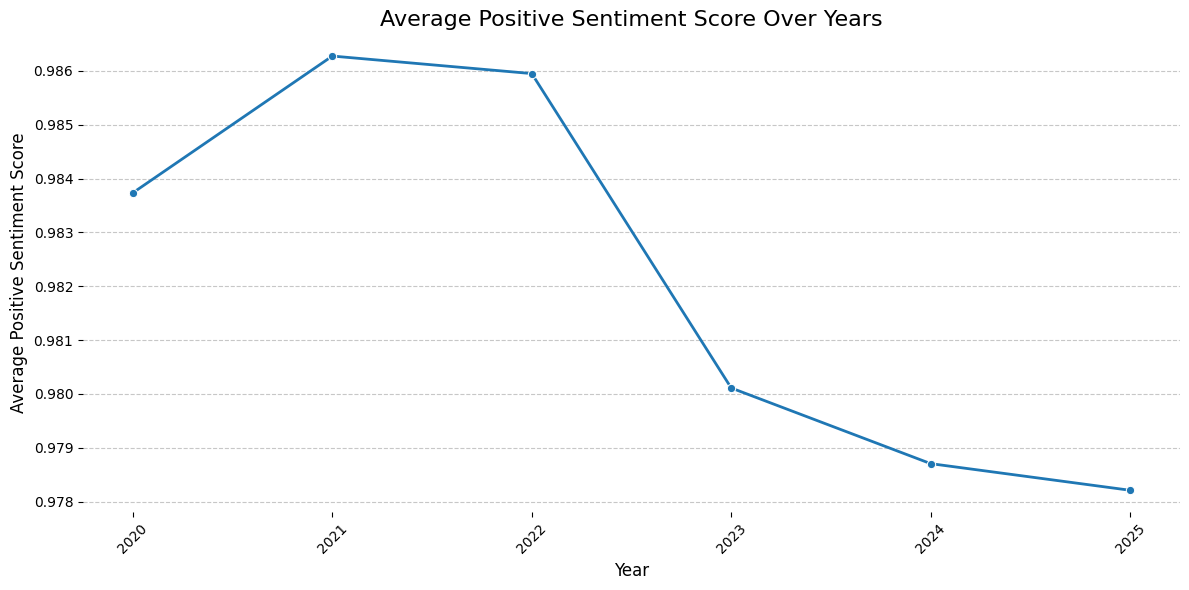

In [ ]:
# Calculate the average sentiment score for each year for positive sentiments only
average_positive_sentiment_by_year = pos_df.groupby('year')['sentiment_score'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sentiment_score', data=average_positive_sentiment_by_year, marker='o', linestyle='-', linewidth=2, palette='coolwarm')
plt.title('Average Positive Sentiment Score Over Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Positive Sentiment Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


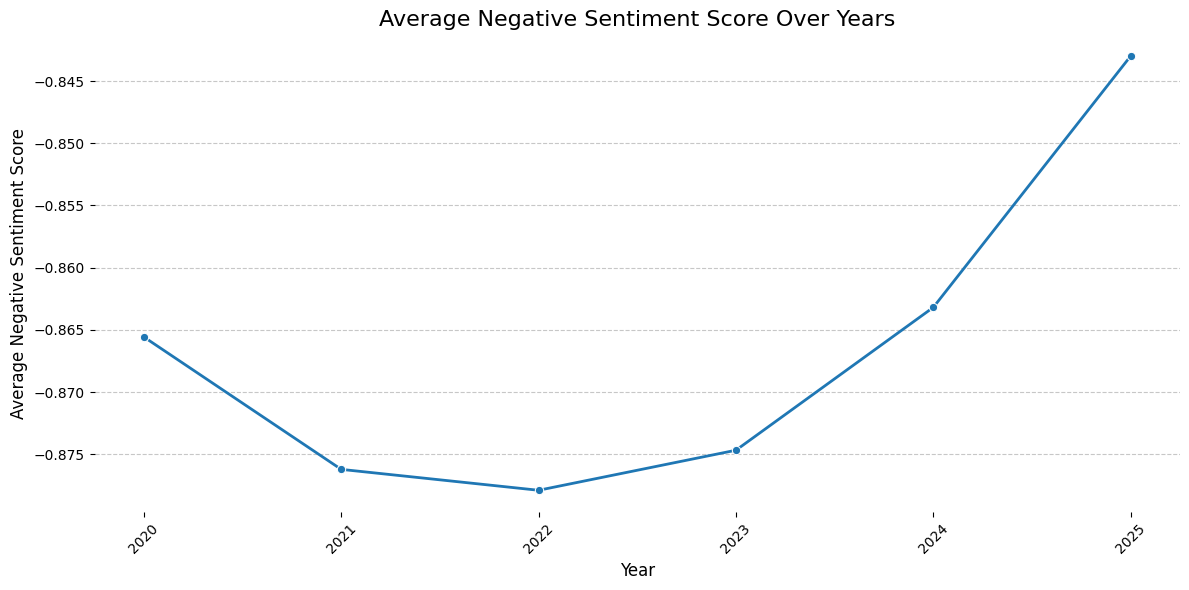

In [ ]:
# Calculate the average sentiment score for each year for positive sentiments only
average_negative_sentiment_by_year = neg_df.groupby('year')['sentiment_score'].mean().reset_index()

# Create the plot
plt.figure(figsize=(12, 6))
sns.lineplot(x='year', y='sentiment_score', data=average_negative_sentiment_by_year, marker='o', linestyle='-', linewidth=2, palette='coolwarm')
plt.title('Average Negative Sentiment Score Over Years', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average Negative Sentiment Score', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()

In [ ]:
pos_max_df = pos_df[pos_df["sentiment_score"]>0.90]
neg_max_df = neg_df[neg_df["sentiment_score"]<-0.90]

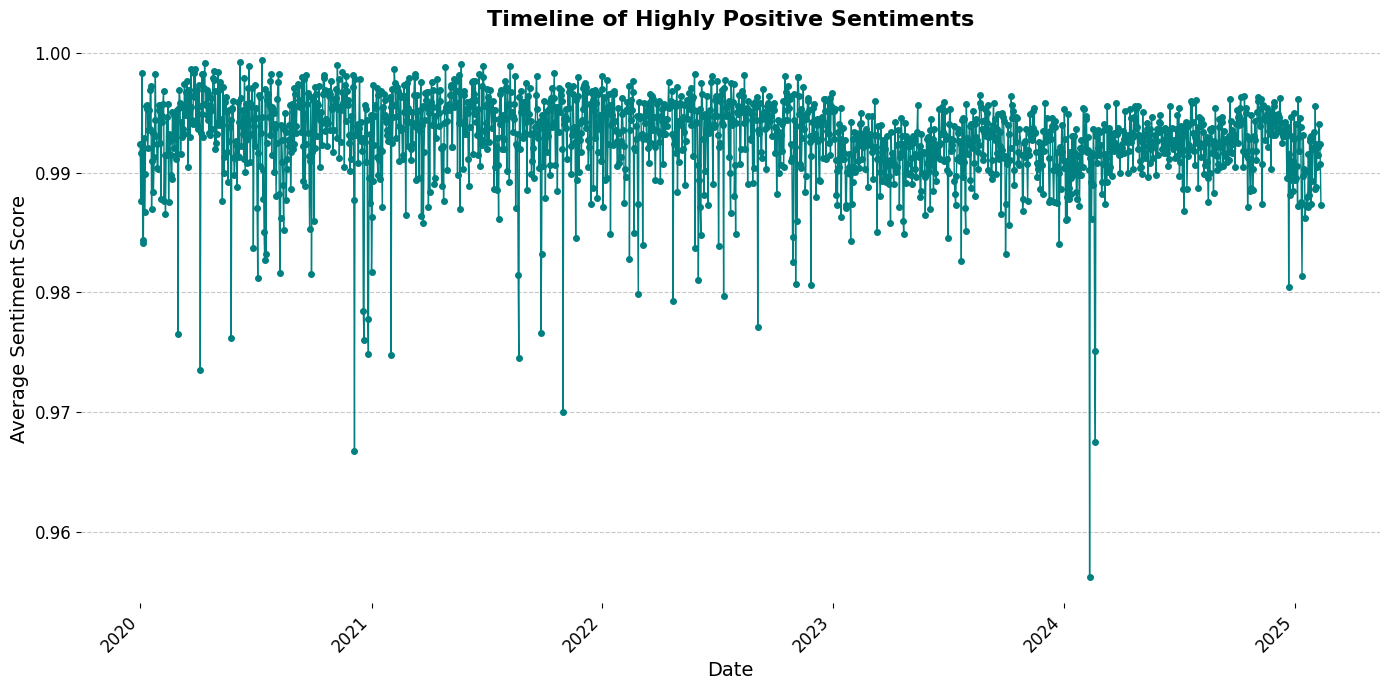

In [ ]:
# Calculate the average sentiment score for each date for highly positive sentiments
pos_max_by_date = pos_max_df.groupby("date")["sentiment_score"].mean()

# Create the plot
plt.figure(figsize=(14, 7))  # Increased figure size for better readability
pos_max_by_date.plot(marker='.', linestyle='-', linewidth=1, color='teal', markersize=8) # Added marker, line style, and color
plt.title("Timeline of Highly Positive Sentiments", fontsize=16, fontweight='bold') # Increased font size and added font weight
plt.xlabel("Date", fontsize=14) # Increased font size
plt.ylabel("Average Sentiment Score", fontsize=14)  # Changed ylabel and increased font size
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotated x-axis labels for readability and increased font size
plt.yticks(fontsize=12)  # Increased font size for y-axis ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Added a subtle grid for better visualization
plt.tight_layout()  # Adjusted layout to prevent labels from overlapping
sns.despine(left=True, bottom=True) # Removed top and right spines
plt.show()


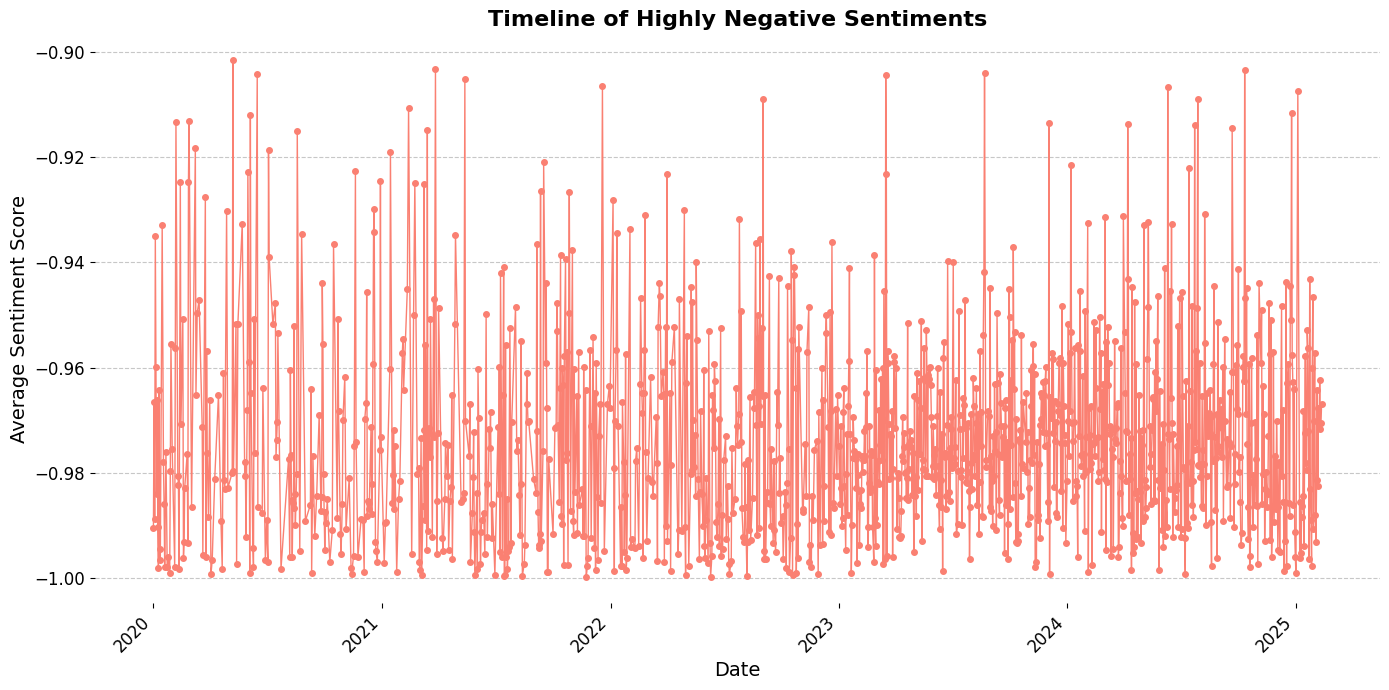

In [ ]:
# Calculate the average sentiment score for each date for highly negative sentiments
neg_max_by_date = neg_max_df.groupby("date")["sentiment_score"].mean()

# Create the plot
plt.figure(figsize=(14, 7))  # Increased figure size for better readability
neg_max_by_date.plot(marker='.', linestyle='-', linewidth=1, color='salmon', markersize=8) # Added marker, line style, and color
plt.title("Timeline of Highly Negative Sentiments", fontsize=16, fontweight='bold') # Increased font size and added font weight
plt.xlabel("Date", fontsize=14) # Increased font size
plt.ylabel("Average Sentiment Score", fontsize=14)  # Changed ylabel and increased font size
plt.xticks(rotation=45, ha='right', fontsize=12)  # Rotated x-axis labels for readability and increased font size
plt.yticks(fontsize=12)  # Increased font size for y-axis ticks
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Added a subtle grid for better visualization
plt.tight_layout()  # Adjusted layout to prevent labels from overlapping
sns.despine(left=True, bottom=True) # Removed top and right spines
plt.show()

In [ ]:
# Save Sentiment Analysis as parquet
df.to_parquet('/content/drive/My Drive/df_sentiment_analysis.parquet', engine = 'pyarrow')